Імпорт бібліотек

In [2]:
import pandas as pd
import numpy as np
from prophet import Prophet
from tqdm import tqdm
import matplotlib.pyplot as plt

Підготовка даних

In [5]:
df = pd.read_csv("forecast_of_market_dataset.csv")

df['month'] = pd.to_datetime(df['month'], errors='coerce')

eval_period = (df['month'] >= '2024-01-01') & (df['month'] <= '2024-12-31')
test_df = df[eval_period].copy()

train_df = df[df['month'] < '2024-01-01'].copy()

forecast_dates = pd.date_range('2024-01-01', '2024-12-01', freq='MS')


Запуск моделі

In [6]:
product_groups = train_df['product_group_id'].unique()
results = []

for group_id in tqdm(product_groups, desc="Forecasting per product group"):
    group_train = train_df[train_df['product_group_id'] == group_id]

    # Loop over both targets
    for target_col in ['market_revenue', 'revenue_amazon']:
        series = group_train[['month', target_col]].dropna()
        series = series.rename(columns={'month': 'ds', target_col: 'y'})

        if len(series) < 12 or series['y'].nunique() <= 1:
            continue  # Skip sparse or flat series

        model = Prophet()
        try:
            model.fit(series)
            future = pd.DataFrame({'ds': forecast_dates})
            forecast = model.predict(future)[['ds', 'yhat']]

            # Add metadata
            forecast['product_group_id'] = group_id
            forecast['target'] = target_col
            results.append(forecast)
        except Exception as e:
            print(f"⚠️ Skipped {target_col} for group {group_id}: {e}")
            continue

Forecasting per product group:   0%|          | 0/29 [00:00<?, ?it/s]22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
Forecasting per product group:   3%|▎         | 1/29 [00:00<00:08,  3.26it/s]22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
Forecasting per product group:   7%|▋         | 2/29 [00:00<00:06,  4.43it/s]22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
Forecasting per product group:  10%|█         | 3/29 [00:00<00:05,  4.36it/s]22:21:59 - cmdstanpy -

Об'єднання результатів прогнозу з фактом

In [7]:
forecast_df = pd.concat(results, ignore_index=True)
actual_df = test_df.melt(
    id_vars=['month', 'product_group_id'],
    value_vars=['market_revenue', 'revenue_amazon'],
    var_name='target',
    value_name='actual'
).rename(columns={'month': 'ds'})

results_merged = pd.merge(forecast_df, actual_df, on=['product_group_id', 'ds', 'target'], how='inner')


Розрахунок метрик

In [8]:
results_merged['abs_error'] = (results_merged['actual'] - results_merged['yhat']).abs()
results_merged['pct_error'] = results_merged['abs_error'] / results_merged['actual'].replace(0, np.nan)
results_merged['weighted_error'] = results_merged['abs_error'] * results_merged['actual']

results_clean = results_merged.dropna(subset=['actual', 'yhat'])


Відображення результатів

In [10]:

metrics = results_clean.groupby('target').agg(
    MAE=('abs_error', 'mean'),
    MAPE=('pct_error', lambda x: np.mean(x.dropna()) * 100)
).reset_index()

wmape_df = results_clean.groupby('target').apply(
    lambda g: (g['weighted_error'].sum() / g['actual'].sum()) * 100
).reset_index().rename(columns={0: 'WMAPE'})

metrics = pd.merge(metrics, wmape_df, on='target')


print(metrics)

           target           MAE       MAPE         WMAPE
0  market_revenue  8.736675e+08  20.923066  2.798600e+11
1  revenue_amazon  9.531871e+07  20.689679  2.488396e+10


/var/folders/jh/5xkpxk417vv8myrv626nkmzh0000gn/T/ipykernel_1776/3305834209.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wmape_df = results_clean.groupby('target').apply(


/var/folders/jh/5xkpxk417vv8myrv626nkmzh0000gn/T/ipykernel_1776/131179108.py:17: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/karina-zaika/Documents/business_forecasting_zaika/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


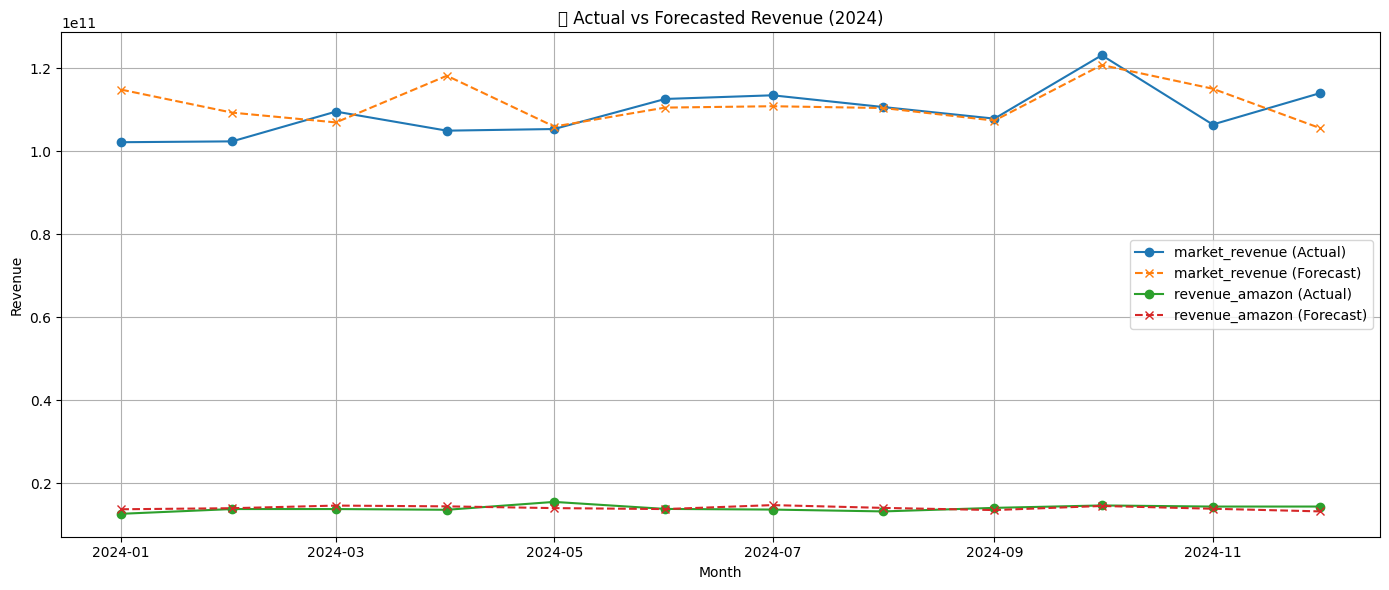

In [11]:

plot_df = results_clean.groupby(['ds', 'target']).agg({
    'actual': 'sum',
    'yhat': 'sum'
}).reset_index()

plt.figure(figsize=(14, 6))
for target in plot_df['target'].unique():
    subset = plot_df[plot_df['target'] == target]
    plt.plot(subset['ds'], subset['actual'], marker='o', label=f"{target} (Actual)")
    plt.plot(subset['ds'], subset['yhat'], marker='x', linestyle='--', label=f"{target} (Forecast)")

plt.title("📉 Actual vs Forecasted Revenue (2024)")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()